This is an example notebook where we produce the "Masquerade plot" for DC2. It is adapted from my work for the Science Pipelines analysis sprint of June 2021.

The masquerade diagnostics amount to looking at the number of detections in annuli of increasing radius around a bright star. The name originates from "mask radius", as this diagnostic was used to select the radius of bright star masks in an older HSC processing set-up (see Coupon et al., 2014).

Note `utils.py` contains a skeleton class to compute the diagnostics and produce the plots, like we do with the Yuanyuan plot. This is a work in progress, so we'll do everything in this notebook (except for the computation of number of detections per annulus, which is done by the `countInAnnulus` free function in `utils.py`.

For an older version on RC2 data, see also: https://github.com/lsst-dm/drp-analysis-sprint-feb20/tree/master/brightStars_DM_sprint_Feb2020

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

from lsst.daf.butler import Butler
from lsst import geom

import sys
sys.path.append('../')
import utils
import os

Set up a butler, take a peak at the collections:

In [3]:
repoPath = "/repo/dc2"
baseRunCollection = "2.2i/runs/test-med-1/w_2021_24/DM-30674"

In [4]:
butler = Butler(repoPath) #, collections=baseRunCollection)

In [5]:
collStub = 'u/mschmitz/'#/DM-25305-again' #extendedPsf/20210315'
myColls = [col for col in list(butler.registry.queryCollections()) if collStub in col]
for coll in myColls: print(coll)

u/mschmitz/DM-27139_singeVisit
u/mschmitz/DM-27139_singeVisit/20210618T162620Z
u/mschmitz/DM-27139_singeVisit/20210618T165144Z
u/mschmitz/DM-27139_singeVisit/20210618T165540Z
u/mschmitz/DM-27139_singeVisit/20210618T170055Z


In [6]:
myColl = "u/mschmitz/DM-27139_singeVisit"

Parameters; data to use:

In [7]:
# data to include
band = "i"
patches = [14, 28, 42, 1, 36, 36, 9, 4, 20, 23, 15]#(21, 24) #list(range(48))
tracts = (3828,) #(3828, 3829)
magCut = 14 # what is "bright"

Masquerade plot-specific parameters:

In [8]:
# Annuli parameters
annSize = 2.5 # radius of each consecutive annulus, in arcsec
radMax = 150 # outer radius for the largest annulus

# Plotting parameters
# magnitude bins and corresponding labels
mag_bins = [0, 12, 14]# + list(range(15,19))
mag_labs = ['mag < 12', '12 < mag < 14']# + [
            #'{} < mag < {}'.format(mfrom,mto)
            #for mfrom,mto in zip(mag_bins[2:],mag_bins[3:])]

# fix y-axis span to 0-to-2.5 times average detection density (as in Coupon et al., 2014, Fig. 8)
fixYAxis = True

# whether to save plots and what to call them
savePlots = True
outputDir = 'plots/'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
plotStub = "2p5rad_upto150"
plotExt = ".png"

# Crude value for the average density; 
# computed beyond 500arcsec (only used to set y-axis span to be the same as the Coupon et al. figure):
avgDen = 0.0525

## 31. Make the plot

Compute annular radii and area:

In [9]:
annRadii = np.arange(0, radMax, annSize)
annAreas = np.array([np.pi *(radOut**2 - radIn**2) for
                     radIn,radOut in zip(annRadii,annRadii[1:])])

Convert to pixel:

In [10]:
pixScale = 0.2
    
# convert annuli parameters to pixel
radMaxPix = radMax / pixScale
radiiPix = annRadii / pixScale

And load the skymap:

In [11]:
skymap = butler.get("skyMap", dataId={'skymap': 'DC2'}, collections=baseRunCollection)

Let's make a convenience function to read the DC2 truth catalog and select bright stars.

Note we're using r magnitude regardless of the band we're looking at. That's fine for the sprint this work was done within; a bright star is a bright star. If we wanted to look at all saturated objects or something, it would be worth making a smarter cut using the flux for the band we are looking at.

While we're at it, have it convert to pixel coordinates if desired.

Also note that this is, of course, very DC2-specific. In the other sprint notebooks linked in the first cell of this one, I used to use Andy Goulding's bright star masks to find bright star centroids. The best would probably be to just use the Gaia (or other) refcat.

In [12]:
def getBrightStarCentroids(tract, magCut=14, convertToPix=False, skymap=None, verbose=False):
    # load truth catalog
    truth = pq.read_pandas(f'/project/shared/DC2/truth_parquet/truth_tract{tract}.parquet').to_pandas()
    if verbose:
        print(f" > Loaded {len(truth)} truth objects.")
    # pick stars
    truth = truth[truth["truth_type"] == 2]
    if verbose:
        print(f"   > including {len(truth)} stars...")
    # keep bright objects 
    truth = truth[truth["mag_r"] < magCut]
    if verbose:
        print(f"   > ... of which {len(truth)} are brighter than r={magCut}...")
    # and keep only one instance of each
    truth = truth[truth["is_unique_truth_entry"]]
    if verbose:
        print(f"   > ... of which {len(truth)} are unique.")
    # centroids
    bsc = np.array(truth.loc[:, ["ra", "dec"]])
    if convertToPix:
        if skymap is None:
            raise AttributeError("convertToPix is True, but no skymap was provided")
        wcs = skymap[tract].getWcs()
        bsc = np.array([wcs.skyToPixel(geom.SpherePoint(cent[0], cent[1], geom.degrees))
                        for cent in bsc])
    return bsc, np.array(truth["mag_r"])

Compute densities in annuli:

In [13]:
densities, magnitudes = [], []
for tract in tracts:
    print(f"Working on tract {tract}")
    bsc, mags = getBrightStarCentroids(tract, magCut, convertToPix=True, skymap=skymap, verbose=True)
    for patch in patches:
        print(f"Working on patch {patch}")
        dataId = {'band': band, 'skymap': 'DC2', 'tract': tract, 'patch': patch}
        meas_coadd = butler.get("deepCoadd_meas", dataId=dataId, collections=baseRunCollection)#drf.dataId)
        for j, (brightCen, mag) in enumerate(zip(bsc, mags)):
            if not j%50:
                print(f"   > Working on bright star {j} ouf of {len(bsc)}...")
            counts, areas = utils.countInAnnulus(meas_coadd, brightCen, radiiPix)
            if counts:
                dens = counts / annAreas#.reshape(1,-1)
                densities.append(dens)
                magnitudes.append(mag)
densities, magnitudes = np.array(densities), np.array(magnitudes)

Working on tract 3828
 > Loaded 4645755 truth objects.
   > including 27446 stars...
   > ... of which 959 are brighter than r=14...
   > ... of which 249 are unique.
Working on patch 14
   > Working on bright star 0 ouf of 249...
   > Working on bright star 50 ouf of 249...
   > Working on bright star 100 ouf of 249...
   > Working on bright star 150 ouf of 249...
   > Working on bright star 200 ouf of 249...
Working on patch 28
   > Working on bright star 0 ouf of 249...
   > Working on bright star 50 ouf of 249...
   > Working on bright star 100 ouf of 249...
   > Working on bright star 150 ouf of 249...
   > Working on bright star 200 ouf of 249...
Working on patch 42
   > Working on bright star 0 ouf of 249...
   > Working on bright star 50 ouf of 249...
   > Working on bright star 100 ouf of 249...
   > Working on bright star 150 ouf of 249...
   > Working on bright star 200 ouf of 249...
Working on patch 1
   > Working on bright star 0 ouf of 249...
   > Working on bright star 5

And plot!

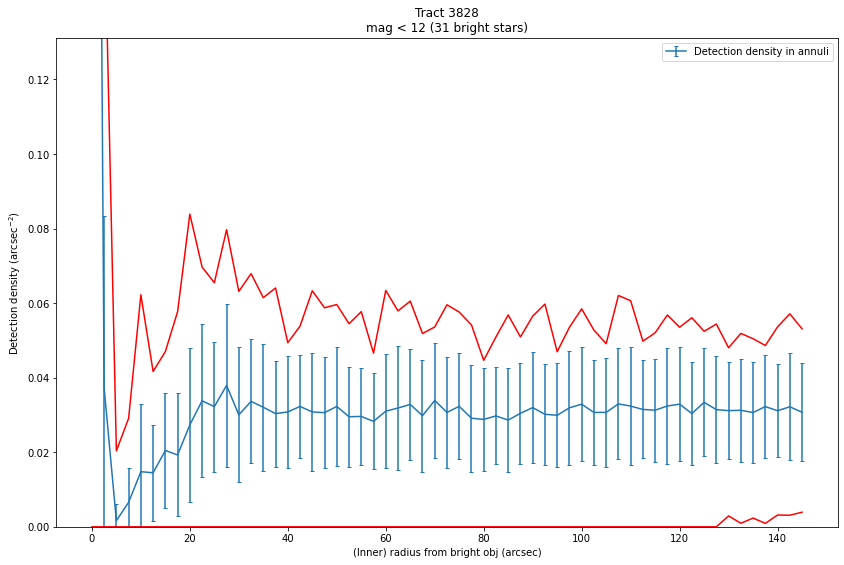

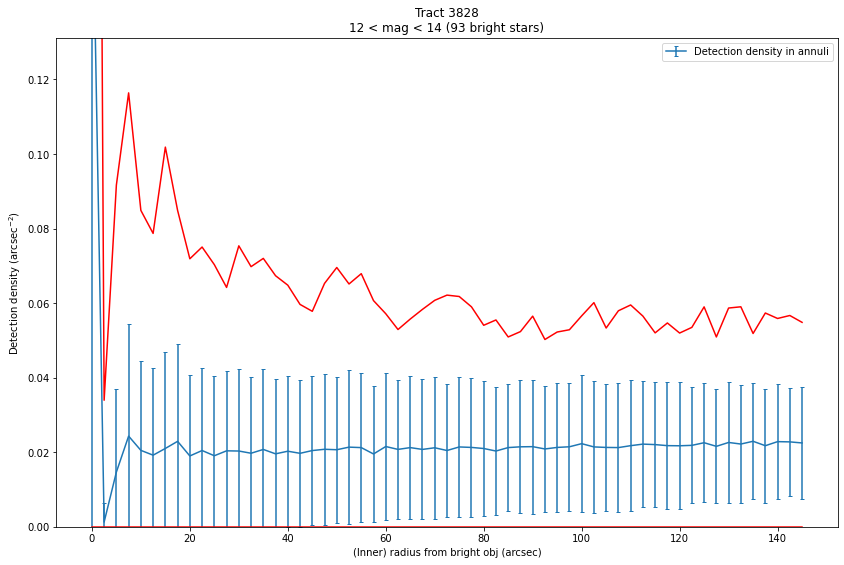

In [14]:
plt.rcParams['figure.figsize'] = 14, 9
for mlab, (mfrom,mto) in zip(mag_labs, zip(mag_bins, mag_bins[1:])):
    binidx = np.array((magnitudes >= mfrom) * (magnitudes < mto))
    # average detection densities around stars in this magnitude bin:
    magDen = np.mean(densities[binidx],axis=0)
    magDenStd = np.std(densities[binidx],axis=0)

    plt.errorbar(annRadii[:-1], magDen, yerr=magDenStd, capsize=2,
                 label='Detection density in annuli')
    plt.plot(annRadii[:-1], np.min(densities[binidx],axis=0), c='red')
    plt.plot(annRadii[:-1], np.max(densities[binidx],axis=0), c='red')

    plt.title("Tract {}\n".format(tract) +
              mlab + " ({} bright stars)".format(np.sum(binidx)))

    plt.xlabel('(Inner) radius from bright obj (arcsec)')
    plt.ylabel(r'Detection density (arcsec$^{-2}$)')
    plt.legend()
    if fixYAxis:
        try:
            plt.ylim(0, 2.5*avgDen)
        except ValueError:
            raise ValueError("Could not set y axis limits; likely because you could not compute\
 average source density")

    if savePlots:
        plt.savefig(outputDir + plotStub + '_{}_tract{}_mag{}_DISTRIB{}'.format(
                    band, tract, mfrom, plotExt))
    plt.show()
    plt.close()

Note this can then be converted to a single scalar per magnitude bin by picking a threshold above average density and looking at the largest radius that is beloz that threshold. This is actually how the mask radii were chosen in the Coupon paper (the "Arcturus" version of HSC bright star masks).

Since this is DC2, and bright stars don't have any halo, we expect these plots to look flat almost all the way to the center of bright objects.